# **Assignment - 3**


Implementing all the essential libraries to perform the NLP

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import nltk 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using the pandas library for dataset reading and manipulation

In [2]:
df = pd.read_csv('reviews.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## **Data Preprocessing**

Starting with the remove_stopwords function which is essential for text preprocessing as it helps in cleaning the text data by removing common words that do not contribute much to the meaning of the sentences.

In [3]:
# stop-words removing and preprocessing steps would go here
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Performing tokenization to create appropriate tokens of the words in order to be able to convert it into vectors.

Applying word2Vec methods in order to get vectoried form with appropriate distance of the words.

Performing padding to reduce weighteage of unwanted vectors and increasing that of the wanted ones.

In [18]:
from collections import Counter
from keras.preprocessing.sequence import pad_sequences


# 1. Build Vocabulary
# We use 10000 to match your model's Embedding layer input_dim
vocab_size = 10000
all_tokens = [token for review_tokens in df['tokens'] for token in review_tokens]
vocab = Counter(all_tokens).most_common(vocab_size - 2) # -2 for <PAD> and <OOV>

# 2. Create word-to-index mapping
word_to_index = {word: i + 2 for i, (word, _) in enumerate(vocab)}
word_to_index['<PAD>'] = 0  # Padding token
word_to_index['<OOV>'] = 1  # Out-of-vocabulary token

# 3. Convert token sequences to integer sequences
sequences = []
for review_tokens in df['tokens']:
    # 1 is the index for <OOV>
    seq = [word_to_index.get(token, 1) for token in review_tokens]
    sequences.append(seq)

# 4. Pad all sequences to a fixed length
max_length = 50 # This was your original max_length
X_sequences = pad_sequences(
    sequences, 
    maxlen=max_length, 
    padding='post',    # Pad at the end
    truncating='post', # Truncate at the end
    value=0            # Use 0 for <PAD>
)

print(f"Shape of padded integer sequences: {X_sequences.shape}")

Shape of padded integer sequences: (50000, 50)


converting the data into training and testing dataset in order to train the model and test it to achieve the results

In [25]:
# Use the new 'X_sequences' from the cell above
X = X_sequences

# FIX: Convert string labels to integers (1 for positive, 0 for negative)
y = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Now the split will work with numeric data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (35000, 50), Validation set size: (7500, 50), Test set size: (7500, 50)


# Model building

Using keras library to build the RNN and the LSTM model using its inbuild functions.

In [26]:
# Using keras for building RNN and LSTM models
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, Flatten


In [20]:
#defining the parameters for RNN and LSTM models
embedding_dim = 200
hidden_units = 128   
learning_rate = 1e-3

Building the RNN and the LSTM model based on the provided parameter and the layers specified.

In [27]:
# defininng RNN and LSTM models
def RNN_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_shape[0]))
    model.add(SimpleRNN(hidden_units, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def LSTM_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_shape[0]))
    
    # FIX: Removed the 'input_shape' argument from the LSTM layer.
    # Keras will infer the shape from the Embedding layer.
    model.add(LSTM(hidden_units, return_sequences=False)) 
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
model_rnn = RNN_model((max_length, 100))
model_lstm = LSTM_model((max_length, 100))
model_rnn.summary()
model_lstm.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the model and testing it on the training and testing datset specified.

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5665 - loss: 0.6804 - val_accuracy: 0.6177 - val_loss: 0.6443
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6473 - loss: 0.6301 - val_accuracy: 0.5265 - val_loss: 0.6994
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7505 - loss: 0.5180 - val_accuracy: 0.7056 - val_loss: 0.5613
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.8316 - loss: 0.3965 - val_accuracy: 0.7520 - val_loss: 0.5231
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.8471 - loss: 0.3596 - val_accuracy: 0.7460 - val_loss: 0.5940
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.7229 - loss: 0.5307 - val_accuracy: 0.6693 - val_loss: 0.6480
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.7421 - loss: 0.5137 - val_accuracy: 0.6227 - val_loss: 0.7357
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.7893 -

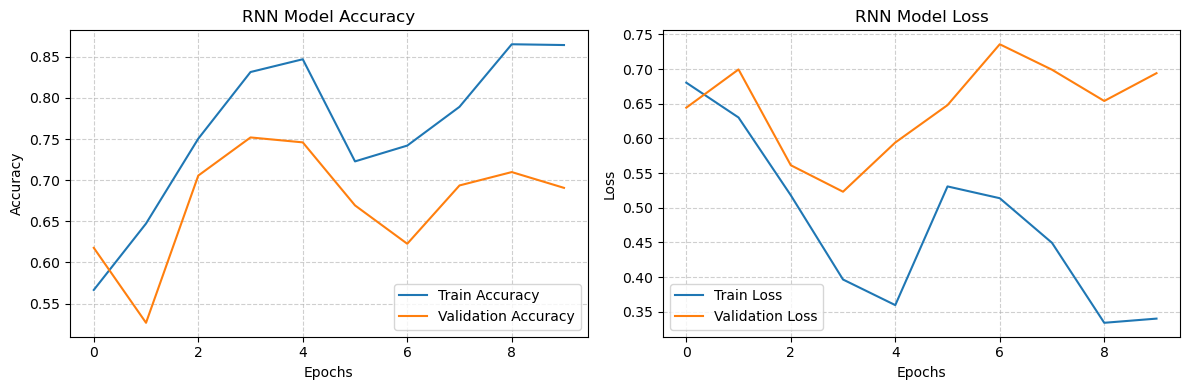

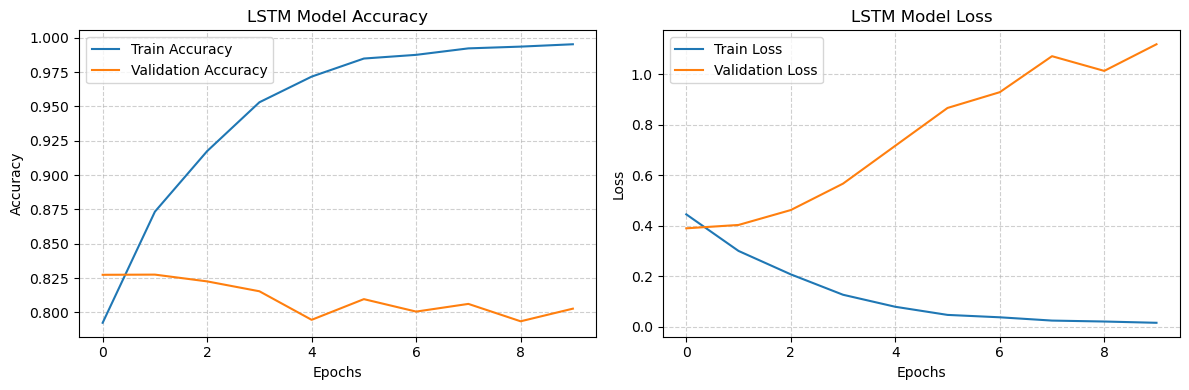

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Convert all your data splits to a numeric type, like float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32) # or np.int32 if they are integer labels
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32) # or np.int32
# ---- train both models ----
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# ---- plotting function ----
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{title} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

# ---- call plots ----
plot_history(history_rnn, "RNN Model")
plot_history(history_lstm, "LSTM Model")


Observing the accuracy and precision and other metrics to decide upon the better model

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get model predictions (flatten to 1D arrays)
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype("int32").flatten()
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32").flatten()

# Make sure y_test is also 1D
y_true = y_test.flatten()

# Calculate metrics safely
accuracy_rnn = accuracy_score(y_true, y_pred_rnn)
precision_rnn = precision_score(y_true, y_pred_rnn, zero_division=0)
recall_rnn = recall_score(y_true, y_pred_rnn, zero_division=0)
f1_rnn = f1_score(y_true, y_pred_rnn, zero_division=0)

accuracy_lstm = accuracy_score(y_true, y_pred_lstm)
precision_lstm = precision_score(y_true, y_pred_lstm, zero_division=0)
recall_lstm = recall_score(y_true, y_pred_lstm, zero_division=0)
f1_lstm = f1_score(y_true, y_pred_lstm, zero_division=0)

print("RNN Model:")
print(f"Accuracy: {accuracy_rnn:.4f}, Precision: {precision_rnn:.4f}, Recall: {recall_rnn:.4f}, F1: {f1_rnn:.4f}")

print("\nLSTM Model:")
print(f"Accuracy: {accuracy_lstm:.4f}, Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1: {f1_lstm:.4f}")



235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
RNN Model:
Accuracy: 0.6971, Precision: 0.7077, Recall: 0.6792, F1: 0.6931

LSTM Model:
Accuracy: 0.8029, Precision: 0.8212, Recall: 0.7782, F1: 0.7991


We can hence observe that LSTM is quite a better model in terms of its Accuracy also its F1 score.